# Optimized triangulation using LabelMe points
The corners of interest of the lattice structures were identified using Labelme. These were then triangulated, and the triangulation was optimized. The code first visualizes matches found using SIFT on both images and their reprojection error with optimization, and then visualizes the points that were hand labeled using LabelMe on both images and their reprojection error after the optimization of triangulation. 

In [1]:
# For input/output
from pathlib import Path

# For numerical methods
import numpy as np

# For image processing and visualization of results
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

# For optimization with symforce
import symforce
symforce.set_epsilon_to_symbol()
import symforce.symbolic as sf
from symforce.values import Values
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce.opt.noise_models import BarronNoiseModel
import sym

In [2]:
def myprint(M):
    if M.shape:
        with np.printoptions(linewidth=150, formatter={'float': lambda x: f'{x:10.4f}'}):
            print(M)
    else:
        print(f'{M:10.4f}')

In [3]:
def apply_transform(R_inB_ofA, p_inB_ofA, p_inA):
    p_inB = np.row_stack([
        (R_inB_ofA @ p_inA_i + p_inB_ofA) for p_inA_i in p_inA
    ])
    return p_inB

def project(K, R_inB_ofA, p_inB_ofA, p_inA, warn=True):
    p_inB = apply_transform(R_inB_ofA, p_inB_ofA, p_inA)
    if not np.all(p_inB[:, 2] > 0):
        if warn:
            print('WARNING: non-positive depths')
    q = np.row_stack([K @ p_inB_i / p_inB_i[2] for p_inB_i in p_inB])
    return q[:, 0:2]

def projection_error(K, R_inB_ofA, p_inB_ofA, p_inA, b, warn=True):
    b_pred = project(K, R_inB_ofA, p_inB_ofA, p_inA, warn=True)
    return np.linalg.norm(b_pred - b, axis=1)

Import the two images 

In [4]:
img1 = cv2.imread("/Users/arnabhardwaj/Downloads/experiment/view_0_b.jpg")#cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
img1= cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread("/Users/arnabhardwaj/Downloads/experiment/view_1_b.jpg")#cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
img2= cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)



In [5]:
# Create a SIFT feature detector
sift = cv2.SIFT_create()

# Apply detector to find keypoints (pts) and descriptors (desc) in each image
pts1, desc1 = sift.detectAndCompute(image=img1, mask=None)
pts2, desc2 = sift.detectAndCompute(image=img2, mask=None)

In [6]:
# Create a brute-force matcher
bf = cv2.BFMatcher(
    normType=cv2.NORM_L2,
    crossCheck=False,       # <-- IMPORTANT - must be False for kNN matching
)

# Function to get good matches with ratio test
def get_good_matches(descA, descB, threshold=0.8):
    # Find the two best matches between descriptors
    matches = bf.knnMatch(descA, descB, k=2)

    # Find the subset of good matches
    good_matches = []
    for m, n in matches:
        if m.distance / n.distance < threshold:
            good_matches.append(m)
    
    # Return good matches, sorted by distance (smallest first)
    return sorted(good_matches, key = lambda m: m.distance)

# Match the two images
matches = get_good_matches(desc1, desc2)
print(f'found {len(matches)} good matches')

found 842 good matches


In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Show images
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')

# Show matches
for m in matches:
    # - Get location of keypoints
    p1 = pts1[m.queryIdx].pt
    p2 = pts2[m.trainIdx].pt
    # - Draw line connecting keypoint in first image with keypoint in second image
    fig.add_artist(
        ConnectionPatch(
            p1, p2, 
            'data', 'data',
            axesA=ax1, axesB=ax2,\
            color='red',
            connectionstyle='arc3, rad=0.',
            linewidth=0.1,
        )
    )
    # - Draw red dot at each keypoint
    ax1.plot(p1[0], p1[1], 'r.', markersize=10)
    ax2.plot(p2[0], p2[1], 'r.', markersize=10)

plt.show()

In [ ]:
K=np.array([[ 3210.7132,     0.0000,  2047.7812],
 [    0.0000,  3220.0556,  1214.7876],
 [    0.0000,     0.0000,     1.0000]])

In [ ]:
# Create a, b
a = []
b = []
for m in matches:
    a.append(pts1[m.queryIdx].pt)
    b.append(pts2[m.trainIdx].pt)
a = np.array(a)
b = np.array(b)

In [10]:
# Get solution
num_inliers_cv, E_cv, R_inB_ofA_cv, p_inB_ofA_cv, mask_cv = cv2.recoverPose(
    a.copy(),
    b.copy(),
    K, np.zeros(4),
    K, np.zeros(4),
)

# Flatten the position (returned as a 2d array by default)
p_inB_ofA_cv = p_inB_ofA_cv.flatten()
mask_cv = mask_cv.flatten()

In [11]:
points = cv2.triangulatePoints(
    K @ np.column_stack([np.eye(3), np.zeros(3)]),
    K @ np.column_stack([R_inB_ofA_cv, p_inB_ofA_cv]),
    a.copy().T,
    b.copy().T,
)

# Normalize points
points /= points[-1, :]

# Extract non-homogeneous coordinates
p_inA_cv = points[0:3, :].T

In [12]:
print(f'OpenCV found {num_inliers_cv} inliers out of {len(mask_cv)}')

OpenCV found 258 inliers out of 842


In [13]:
a_inliers_cv = np.array([a_i for a_i, mask_i in zip(a, mask_cv) if mask_i])
b_inliers_cv = np.array([b_i for b_i, mask_i in zip(b, mask_cv) if mask_i])
assert(len(a_inliers_cv) == np.count_nonzero(mask_cv))
assert(len(b_inliers_cv) == np.count_nonzero(mask_cv))

p_inA_inliers_cv = np.array([p_inA_i for p_inA_i, mask_i in zip(p_inA_cv, mask_cv) if mask_i])
assert(len(p_inA_inliers_cv) == np.count_nonzero(mask_cv))

a_outliers_cv = np.array([a_i for a_i, mask_i in zip(a, mask_cv) if not mask_i])
b_outliers_cv = np.array([b_i for b_i, mask_i in zip(b, mask_cv) if not mask_i])
p_inA_outliers_cv = np.array([p_inA_i for p_inA_i, mask_i in zip(p_inA_cv, mask_cv) if not mask_i])

In [14]:
# For inliers
e_a_inliers_cv = projection_error(K, np.eye(3), np.zeros(3), p_inA_inliers_cv, a_inliers_cv)
e_b_inliers_cv = projection_error(K, R_inB_ofA_cv, p_inB_ofA_cv, p_inA_inliers_cv, b_inliers_cv)

# For outliers
e_a_outliers_cv = projection_error(K, np.eye(3), np.zeros(3), p_inA_outliers_cv, a_outliers_cv)
e_b_outliers_cv = projection_error(K, R_inB_ofA_cv, p_inB_ofA_cv, p_inA_outliers_cv, b_outliers_cv)

In [15]:
def skew(v):
    assert(type(v) == np.ndarray)
    assert(v.shape == (3,))
    return np.array([[0., -v[2], v[1]],
                     [v[2], 0., -v[0]],
                     [-v[1], v[0], 0.]])


In [16]:
#This is the process of finding the essential matrix. See theory above. 
def findE(alpha_calc, beta_calc):
    matrix= []
    for i in range (0, len(alpha_calc)):
        matrix.append(np.kron(alpha_calc[i], beta_calc[i]).T)

    matrix= np.array(matrix)



    Udprime, Sdprime, Vtdprime= np.linalg.svd(matrix)


    Edprime= Vtdprime[-1]
    Edprime= Edprime.reshape((3, 3)).T


    E_norm= (np.sqrt(2)/ np.linalg.norm(Edprime))


    Eprime= E_norm*Edprime

    Uprime, Sprime, Vtprime= np.linalg.svd(Eprime)

    Vprime= Vtprime.T


    u1prime= Uprime[:, 0]
    u2prime= Uprime[:, 1]
    u3prime= Uprime[:, 2]


    U= np.hstack((u1prime, u2prime, np.linalg.det(Uprime)*u3prime))

    U= U.reshape(3,3).T


    S= np.diag((1, 1, 0))


    v1prime= Vtprime[:, 0]
    v2prime= Vtprime[:, 1]
    v3prime= Vtprime[:, 2]


    V= np.hstack((v1prime, v2prime, np.linalg.det(Vtprime)*v3prime))

    V=V.reshape((3, 3))

    W= np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    E= U@S@V.T


    u3= U[:, -1]
    
    
    return E, W, V, U, u3




In [17]:
#This is the process of using Ransac to find the optimal essential matrix. See theory above. 
def get_bestE(a, b):
    alpha_calc = np.array([np.linalg.inv(K) @ np.concatenate([a_i, [1.]]) for a_i in a])
    beta_calc = np.array([np.linalg.inv(K) @ np.concatenate([b_i, [1.]]) for b_i in b])
    num_inliers_best=0
    E_best=None
    W_best= None
    V_best= None
    U_best= None
    u3_best= None

    epsilon=1e-3
    
    
    for i in range (0, 500):

        nums = np.random.randint(0, alpha_calc.shape[0] , size=8)
        alphas = np.array([alpha_calc[i] for i in nums])
        betas = np.array([beta_calc[i] for i in nums])
        epsilon= 1e-3
        
        E_, W, V, U, u3= findE(alphas, betas)

        num_inliers=0
        for i in range (0, len(alpha_calc)):
            e3=np.array([0, 0, 1])
            e3_skew= skew(e3)
            
            alpha_i = alpha_calc[i]
            beta_i = beta_calc[i]
            dBi = np.abs((beta_i.T @ E_@ alpha_i) / np.linalg.norm(e3_skew @ E_ @ alpha_i))
            dAi = np.abs((alpha_i.T @ E_.T @ beta_i) / np.linalg.norm(e3_skew @ E_.T @ beta_i))
            
            if dBi<epsilon and dAi<epsilon: 
                num_inliers+=1
            
        if num_inliers > num_inliers_best:
            E_best = E_
            W_best= W
            V_best= V
            U_best= U
            u3_best =u3
            
            num_inliers_best = num_inliers

    
    return E_best, W_best, V_best, U_best, u3_best
                


In [18]:
def skew(v):
    assert(type(v) == np.ndarray)
    assert(v.shape == (3,))
    return np.array([[0., -v[2], v[1]],
                     [v[2], 0., -v[0]],
                     [-v[1], v[0], 0.]])

#The theory for the two view triangulation is taken from the corresponding in class activity
def twoview_triangulate(alpha, beta, R_inB_ofA, p_inB_ofA):
    # INPUTS (alpha, beta, R_inB_ofA, p_inB_ofA)
    #  alpha        normalized coordinates of points in image A
    #  beta         normalized coordinates of points in image B
    #  R_inB_ofA    orientation of frame A in frame B
    #  p_inB_ofA    position of frame A in frame B
    #
    # OUTPUTS (p_inA, p_inB, mask)
    #  p_inA        triangulated points in frame A
    #  p_inB        triangulated points in frame B
    #  mask         1d array of length equal to number of triangulated points,
    #               with a "1" for each point that has positive depth in both
    #               frames and with a "0" otherwise

    
    lambda_a=[]
    lambda_b=[]
    p_inA_arr=[]
    p_inB_arr=[]

    
    mask=[]
    for i in range(0, len(alpha)):
        u= skew(beta[i].flatten())@R_inB_ofA@alpha[i].flatten()
        v= -skew(beta[i].flatten())@p_inB_ofA
    
        lambdaa= u.T@v/ (u.T@u)
                
        lambda_a.append(lambdaa)
        
        lambdab= np.array([0, 0, 1]).T@(lambdaa*R_inB_ofA@alpha[i].flatten()+ p_inB_ofA)
    
        lambda_b.append(lambdab)
        beta_i= np.array(beta[i])
        
        alphai= alpha[i].flatten()
                
        left_matrix= np.hstack((-skew((beta_i))@p_inB_ofA, np.zeros(len(p_inB_ofA)))) #changed
        right_matrix=np.vstack((skew(beta_i)@R_inB_ofA, skew(alphai)))
        
        p_inAi= np.linalg.pinv(right_matrix)@left_matrix
        
        p_inBi= R_inB_ofA@p_inAi+p_inB_ofA
        
        
        p_inA_arr.append(p_inAi)
        p_inB_arr.append(p_inBi)
        
           
    
    p_inA = p_inA_arr
    
    p_inA= np.array(p_inA).reshape(-1, 3)
    
    p_inA= np.array(p_inA)
    p_inB = np.array(p_inB_arr).reshape(-1, 3)
    
    p_inB= np.array(p_inB)
    
    mask=[]
    for i in range (0, len(lambda_a)):
        if lambda_a[i]>=0 and lambda_b[i]>=0:
            mask.append(1)
            
        else:
            mask.append(0)

    mask=np.array(mask) 
    return p_inA, p_inB, np.sum(mask)

#The theory for 2 view reconstruction is taken from the in class activity 
def twoview(a, b, K):
    # INPUTS (a, b, K)
    #  a            image coordinates of points in image A (n x 2)
    #  b            image coordinates of points in image B (n x 2)
    #  K            camera matrix

    # OUTPUTS (E, R_inB_ofA, p_inB_ofA, p_inA)
    #  E            estimate of essential matrix
    #  R_inB_ofA    estimate of orientation of frame A in frame B
    #  p_inB_ofA    estimate of position of frame A in frame B
    #  p_inA        estimate of triangulated position of points in frame A
        
    alpha_calc = np.array([np.linalg.inv(K) @ np.concatenate([a_i, [1.]]) for a_i in a])
    beta_calc = np.array([np.linalg.inv(K) @ np.concatenate([b_i, [1.]]) for b_i in b])

    E, W, V, U, u3= get_bestE(a, b)

    
    mask_sums=[]
    R_inB_ofAs=[]
    p_inB_ofAs=[]
    p_inAs=[]
        ##########Trial 1#############
    R_inB_ofA1= U@W.T@V.T
    p_inB_ofA1= u3
    p_inA1, p_inB, mask = twoview_triangulate(alpha_calc, beta_calc, R_inB_ofA1, p_inB_ofA1)
    
    p_inAs.append(p_inA1)
    mask_sums.append(mask)
    R_inB_ofAs.append(R_inB_ofA1)
    p_inB_ofAs.append(p_inB_ofA1)

   
    #########Trial 2############

    R_inB_ofA2= U@W@V.T
    p_inB_ofA2= -u3
    p_inA2, p_inB, mask = twoview_triangulate(alpha_calc, beta_calc, R_inB_ofA2, p_inB_ofA2)
    
    p_inAs.append(p_inA2)    
    mask_sums.append(mask)
    R_inB_ofAs.append(R_inB_ofA2)
    p_inB_ofAs.append(p_inB_ofA2)

  
    #########Trial 3################
    
    R_inB_ofA3= U@W.T@V.T
    p_inB_ofA3= -u3
    p_inA3, p_inB, mask = twoview_triangulate(alpha_calc, beta_calc, R_inB_ofA3, p_inB_ofA3)

    p_inAs.append(p_inA3)
    mask_sums.append(mask)
    R_inB_ofAs.append(R_inB_ofA3)
    p_inB_ofAs.append(p_inB_ofA3)

    
    ##########Trial 4###############
    
    R_inB_ofA4= U@W@V.T
    p_inB_ofA4= u3
    p_inA4, p_inB, mask = twoview_triangulate(alpha_calc, beta_calc, R_inB_ofA4, p_inB_ofA4)
    
    p_inAs.append(p_inA4)
    mask_sums.append(mask)
    R_inB_ofAs.append(R_inB_ofA4)
    p_inB_ofAs.append(p_inB_ofA4)

    
    highest_mask = max(mask_sums)
    max_index = mask_sums.index(highest_mask)
    print(mask_sums)
    print(max_index)
    

    
    
    return E, R_inB_ofAs[max_index], p_inB_ofAs[max_index], p_inAs[max_index]

In [19]:
# Get estimate
#num_inliers_cv, E_cv, R_inB_ofA_cv, p_inB_ofA_cv, mask_cv

E, R_inB_ofA, p_inB_ofA, p_inA = twoview(a, b, K)

# Get reprojection errors
e_a = projection_error(K, np.eye(3), np.zeros(3), p_inA, a)
e_b = projection_error(K, R_inB_ofA_cv, p_inB_ofA_cv, p_inA_cv, b)

[213, 19, 457, 40]
2


Optimization of sift labeled points 

In [20]:
def sf_projection(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,
) -> sf.V2:
    p_inC = T_inC_ofW * p_inW
    z = sf.Max(p_inC[2], epsilon)  # <-- points with non-positive depth will have large but finite error
    return sf.V2(
        fx * (p_inC[0] / z) + cx,
        fy * (p_inC[1] / z) + cy,
    )

In [21]:
def sf_projection_residual(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    q: sf.V2,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,  
) -> sf.V2:
    q_proj = sf_projection(T_inC_ofW, p_inW, fx, fy, cx, cy, epsilon)

    # Find the reprojection error
    unwhitened_residual = sf.V2(q_proj - q)
    
    # Create a "noise model" that allows us to implement the Geman-McClure robust loss function
    noise_model = BarronNoiseModel(
        alpha=-2,
        scalar_information=1,
        x_epsilon=epsilon,
        alpha_epsilon=epsilon,
    )
    
    # Return the "whitened residual" that corresponds to the robust loss function
    return noise_model.whiten_norm(unwhitened_residual)

In [22]:
def sf_scale_residual(
    T_inC_ofW: sf.Pose3,
    epsilon: sf.Scalar,
) -> sf.V1:
    return sf.V1(T_inC_ofW.t.norm() - 1)

In [23]:
initial_values = Values(
    T_inA_ofA=sym.Pose3(
        R=sym.Rot3.from_rotation_matrix(np.eye(3)),
        t=np.zeros(3),
    ),
    T_inB_ofA=sym.Pose3(
        R=sym.Rot3.from_rotation_matrix(R_inB_ofA),
        t=p_inB_ofA,
    ),
    matches=[],
    fx=K[0, 0],
    fy=K[1, 1],
    cx=K[0, 2],
    cy=K[1, 2],
    epsilon=sym.epsilon,
)
for a_i, b_i, p_inA_i in zip(a, b, p_inA):
    match = Values(
        a=a_i,
        b=b_i,
        p_inA=p_inA_i,
    )
    initial_values['matches'].append(match)


In [24]:
factors = [
    Factor(
        residual=sf_scale_residual,
        keys=[
            'T_inB_ofA',
            'epsilon',
        ],
    )
]
for i_match, match in enumerate(initial_values['matches']):
    factors.append(Factor(
        residual=sf_projection_residual,
        keys=[
            'T_inA_ofA',
            f'matches[{i_match}].p_inA',
            f'matches[{i_match}].a',
            'fx',
            'fy',
            'cx',
            'cy',
            'epsilon',
        ],
    ))
    factors.append(Factor(
        residual=sf_projection_residual,
        keys=[
            'T_inB_ofA',
            f'matches[{i_match}].p_inA',
            f'matches[{i_match}].b',
            'fx',
            'fy',
            'cx',
            'cy',
            'epsilon',
        ],
    ))
    
print(initial_values)

Values(
  T_inA_ofA: <Pose3 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]>,
  T_inB_ofA: <Pose3 [-0.00835829161561673, -0.0744790536572893, 0.010302568934735573, 0.9971343272603386, -0.003816810062039238, -0.09040917533144037, -0.9958973907872425]>,
  matches: [Values(
  a: [1586.20178223  453.24267578],
  b: [1068.71862793  437.70373535],
  p_inA: [-4.56565562 -7.49613298 31.72074577],
), Values(
  a: [1699.97033691  438.66040039],
  b: [1186.43603516  423.88504028],
  p_inA: [-2.90111483 -6.42057275 26.68290329],
), Values(
  a: [1374.38183594  530.04724121],
  b: [843.03295898 514.39306641],
  p_inA: [-8.99572978 -9.11951655 42.8885039 ],
), Values(
  a: [2304.53564453 1635.20471191],
  b: [1733.8404541  1667.40197754],
  p_inA: [0.26272974 0.37741424 3.16672091],
), Values(
  a: [3961.92407227  484.0149231 ],
  b: [3545.24926758  500.29693604],
  p_inA: [ 4.58973232 -1.75075869  7.70253722],
), Values(
  a: [1305.9597168   508.99990845],
  b: [774.60150146 487.0428772 ],
  p_inA: [-10.994305

In [25]:
optimized_keys = ['T_inB_ofA']
for i_match, match in enumerate(initial_values['matches']):
    optimized_keys.append(f'matches[{i_match}].p_inA')
optimizer = Optimizer(
    factors=factors,
    optimized_keys=optimized_keys,
    debug_stats=True,
    params=Optimizer.Params(
        iterations=250,
        use_diagonal_damping=True,      # <-- this makes a big difference (try turning it off!)
    ),
)

In [26]:
result = optimizer.optimize(initial_values)
assert(result.status == Optimizer.Status.SUCCESS)

[2024-05-10 21:08:36.319] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 2.993e+03/0.000e+00/2.957e+03, rel reduction: 1.20177e-02
[2024-05-10 21:08:36.532] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 2.957e+03/0.000e+00/2.926e+03, rel reduction: 1.05204e-02
[2024-05-10 21:08:36.740] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 2.926e+03/0.000e+00/2.863e+03, rel reduction: 2.13245e-02
[2024-05-10 21:08:36.951] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 2.863e+03/0.000e+00/2.841e+03, rel reduction: 7.76902e-03
[2024-05-10 21:08:37.161] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 2.841e+03/0.000e+00/2.842e+03, rel reduction: -2.64930e-04
[2024-05-10 21:08:37.375] [info] LM<sym::Optimize> [iter    5] lambda: 1.562e-02, error prev/linear/new: 2.841e+03/0.000e+00/2.830e+03, rel reduction: 3.79758e-03
[2024-05-10 21:08:37.

[2024-05-10 21:08:47.028] [info] LM<sym::Optimize> [iter   51] lambda: 3.815e-06, error prev/linear/new: 2.784e+03/0.000e+00/2.784e+03, rel reduction: 1.48078e-05
[2024-05-10 21:08:47.233] [info] LM<sym::Optimize> [iter   52] lambda: 9.537e-07, error prev/linear/new: 2.784e+03/0.000e+00/2.784e+03, rel reduction: -3.86136e-06
[2024-05-10 21:08:47.440] [info] LM<sym::Optimize> [iter   53] lambda: 3.815e-06, error prev/linear/new: 2.784e+03/0.000e+00/2.784e+03, rel reduction: -1.20273e-05
[2024-05-10 21:08:47.649] [info] LM<sym::Optimize> [iter   54] lambda: 1.526e-05, error prev/linear/new: 2.784e+03/0.000e+00/2.784e+03, rel reduction: -1.36729e-05
[2024-05-10 21:08:47.849] [info] LM<sym::Optimize> [iter   55] lambda: 6.104e-05, error prev/linear/new: 2.784e+03/0.000e+00/2.784e+03, rel reduction: -1.39011e-05
[2024-05-10 21:08:48.062] [info] LM<sym::Optimize> [iter   56] lambda: 2.441e-04, error prev/linear/new: 2.784e+03/0.000e+00/2.784e+03, rel reduction: 2.44435e-06
[2024-05-10 21:08:

In [27]:
T_inB_ofA_sf = result.optimized_values['T_inB_ofA'].to_homogenous_matrix()
R_inB_ofA_sf = T_inB_ofA_sf[0:3, 0:3]
p_inB_ofA_sf = T_inB_ofA_sf[0:3, 3]
p_inA_sf = np.array([
    match['p_inA'] for match in result.optimized_values['matches']
])

In [28]:
e_a_sf = projection_error(K, np.eye(3), np.zeros(3), p_inA_sf, a)
e_b_sf = projection_error(K, R_inB_ofA_sf, p_inB_ofA_sf, p_inA_sf, b)


In [29]:
def show_stats(e_a, e_b):
    print(f'A ({len(e_a):5d}) : (mean, std, max, min) = ({np.mean(e_a):4.2f}, {np.std(e_a):4.2f}, {np.max(e_a):4.2f}, {np.min(e_a):4.2f})')
    print(f'B ({len(e_b):5d}) : (mean, std, max, min) = ({np.mean(e_b):4.2f}, {np.std(e_b):4.2f}, {np.max(e_b):4.2f}, {np.min(e_b):4.2f})')

In [30]:
print('ESTIMATES')
print('\nCV')
myprint(R_inB_ofA_cv)
myprint(p_inB_ofA_cv)
print('\nYOURS (initial guess)')
myprint(R_inB_ofA)
myprint(p_inB_ofA)
print('\nYOURS (optimized)')
myprint(R_inB_ofA_sf)
myprint(p_inB_ofA_sf)


ESTIMATES

CV
[[    0.9999    -0.0089    -0.0098]
 [    0.0091     0.9999     0.0147]
 [    0.0097    -0.0148     0.9998]]
[   -0.9647    -0.0679    -0.2544]

YOURS (initial guess)
[[    0.9887    -0.0193    -0.1487]
 [    0.0218     0.9996     0.0151]
 [    0.1484    -0.0182     0.9888]]
[   -0.0038    -0.0904    -0.9959]

YOURS (optimized)
[[    0.9889    -0.0184    -0.1477]
 [    0.0210     0.9997     0.0158]
 [    0.1474    -0.0187     0.9889]]
[   -0.0114    -0.0934    -0.9148]


In [31]:
print('REPROJECTION ERRORS')
print('\nCV (inliers)')
show_stats(e_a_inliers_cv, e_b_inliers_cv)
print('\nCV (outliers)')
show_stats(e_a_outliers_cv, e_b_outliers_cv)
print('\nYOURS (initial guess)')
show_stats(e_a, e_b)
print('\nYOURS (optimized)')
show_stats(e_a_sf, e_b_sf)
threshold = 0.5
print('\nYOURS (optimized, with statistics only over erros less than {threshold} px)')
show_stats(
    np.array([e_a_sf_i for e_a_sf_i in e_a_sf if e_a_sf_i < threshold]),
    np.array([e_b_sf_i for e_b_sf_i in e_b_sf if e_b_sf_i < threshold]),
)

b0plot=[]
b1plot=[]
a_pred = project(K, np.eye(3), np.zeros(3), p_inA)
b_pred = project(K, R_inB_ofA, p_inB_ofA, p_inA)

a_pred_plot=[]
b_pred_plot=[]

#only keep a, b, and their predicted reprojections if they are below a certain threshold
for i in range(len(p_inA_sf)):
    if e_a_sf[i] < threshold and e_b_sf[i] < threshold:
        b0plot.append(a[i])
        b1plot.append(b[i])
        a_pred_plot.append(a_pred[i])
        b_pred_plot.append(b_pred[i])
        
b0plot=np.array(b0plot)
b1plot=np.array(b1plot)
a_pred_plot= np.array(a_pred_plot)
b_pred_plot= np.array(b_pred_plot)


REPROJECTION ERRORS

CV (inliers)
A (  258) : (mean, std, max, min) = (0.33, 0.19, 0.69, 0.00)
B (  258) : (mean, std, max, min) = (0.35, 0.20, 0.72, 0.00)

CV (outliers)
A (  584) : (mean, std, max, min) = (145.67, 187.67, 1142.28, 0.20)
B (  584) : (mean, std, max, min) = (145.50, 186.51, 1020.90, 0.20)

YOURS (initial guess)
A (  842) : (mean, std, max, min) = (549.78, 4162.08, 113410.67, 0.01)
B (  842) : (mean, std, max, min) = (101.03, 169.13, 1020.90, 0.00)

YOURS (optimized)
A (  842) : (mean, std, max, min) = (21502.32, 341215.12, 9815083.35, 0.00)
B (  842) : (mean, std, max, min) = (33024.57, 558729.39, 16023725.68, 0.00)

YOURS (optimized, with statistics only over erros less than {threshold} px)
A (  149) : (mean, std, max, min) = (0.11, 0.15, 0.50, 0.00)
B (   79) : (mean, std, max, min) = (0.18, 0.16, 0.49, 0.00)


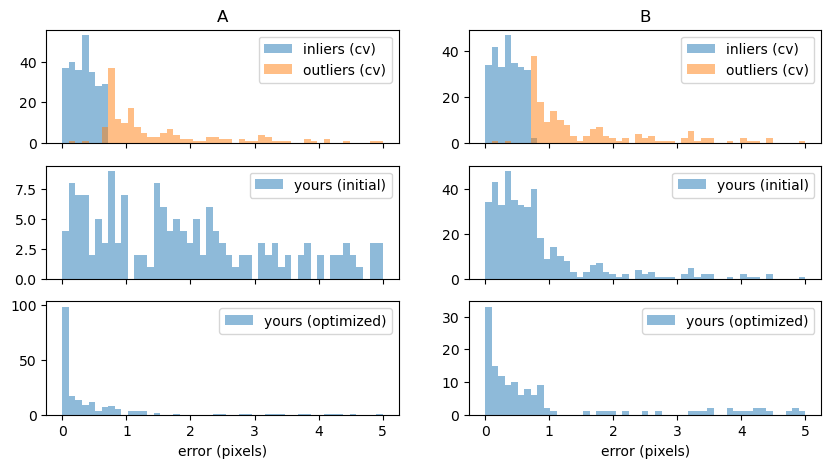

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(10, 5), sharex=True)
bins = np.linspace(0, 5, 50)

ax[0, 0].hist(e_a_inliers_cv, bins, alpha=0.5, label=f'inliers (cv)')
ax[0, 0].hist(e_a_outliers_cv, bins, alpha=0.5, label=f'outliers (cv)')
ax[0, 0].legend()
ax[0, 1].hist(e_b_inliers_cv, bins, alpha=0.5, label=f'inliers (cv)')
ax[0, 1].hist(e_b_outliers_cv, bins, alpha=0.5, label=f'outliers (cv)')
ax[0, 1].legend()
ax[0, 0].set_title(f'A')
ax[0, 1].set_title(f'B')

ax[1, 0].hist(e_a, bins, alpha=0.5, label=f'yours (initial)')
ax[1, 0].legend()
ax[1, 1].hist(e_b, bins, alpha=0.5, label=f'yours (initial)')
ax[1, 1].legend()

ax[2, 0].hist(e_a_sf, bins, alpha=0.5, label=f'yours (optimized)')
ax[2, 0].legend()
ax[2, 1].hist(e_b_sf, bins, alpha=0.5, label=f'yours (optimized)')
ax[2, 1].legend()

ax[2, 0].set_xlabel('error (pixels)')
ax[2, 1].set_xlabel('error (pixels)')
plt.show()

A visualization of the SIFT found matches and their reprojections

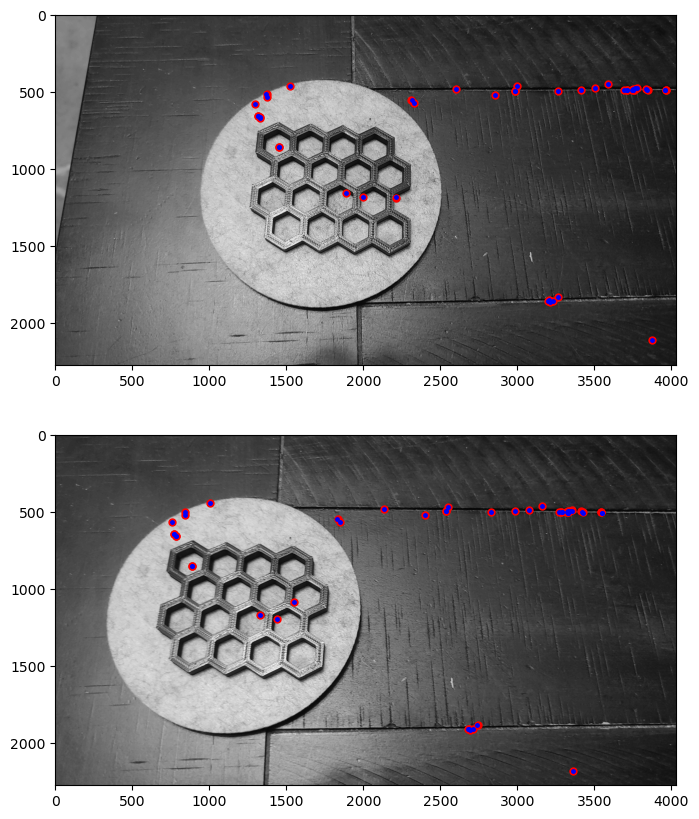

In [33]:
# Sample code with reduced number of points and increased marker size
import matplotlib.pyplot as plt

# Create figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

# Show images
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')

# Plot points
ax1.plot(b0plot[:, 0], b0plot[:, 1], 'r.', markersize=10)
ax1.plot(a_pred_plot[:, 0], a_pred_plot[:, 1], 'b.', markersize=5)  # Increased marker size


ax2.plot(b1plot[:, 0], b1plot[:, 1], 'r.', markersize=10)
ax2.plot(b_pred_plot[:, 0], b_pred_plot[:, 1], 'b.', markersize = 5)
plt.show()


Using the metadata from labelme, extract the image coordinates of the hand-labeled points for both images

In [35]:
import json
with open('/Users/arnabhardwaj/Downloads/experiment/view_0_b.json') as user_file:
    file_contents = user_file.read()
data = json.loads(file_contents)

for obj in data['shapes']:
    label = obj['label']
    points=obj['points']

    
label_points_dict = {}

for obj in data['shapes']:
    label = obj['label']
    points = obj['points']
    label_points_dict[label] = points

#print(label_points_dict['img boundaries (clkwise starting bottom-left)'])

# label_points_dict['hex 1']

b0 = data['shapes'][0]['points']

for obj in data['shapes'][1:-1]:
    points = obj['points']
    b0 = np.concatenate((b0, points), axis=0)
    
b0 = np.array(b0)


In [36]:
with open('/Users/arnabhardwaj/Downloads/experiment/view_1_b.json') as user_file:
    file_contents = user_file.read()
data = json.loads(file_contents)

for obj in data['shapes']:
    label = obj['label']
    points=obj['points']

    
label_points_dict = {}

for obj in data['shapes']:
    label = obj['label']
    points = obj['points']
    label_points_dict[label] = points

#print(label_points_dict['img boundaries (clkwise starting bottom-left)'])

# label_points_dict['hex 1']

b1 = data['shapes'][0]['points']

for obj in data['shapes'][1:-1]:
    points = obj['points']
    b1 = np.concatenate((b1, points), axis=0)
    
b1 = np.array(b1)


Perform triangulation with the labelme points and the optimized $R_B^A$ and $p_B^A$ that was found from the SIFT matching optimization

In [37]:
b0_calc = np.array([np.linalg.inv(K) @ np.concatenate([a_i, [1.]]) for a_i in b0])
b1_calc = np.array([np.linalg.inv(K) @ np.concatenate([b_i, [1.]]) for b_i in b1])

p_inA_new, p_inB_new, mask= twoview_triangulate(b0_calc, b1_calc, R_inB_ofA_sf, p_inB_ofA_sf)

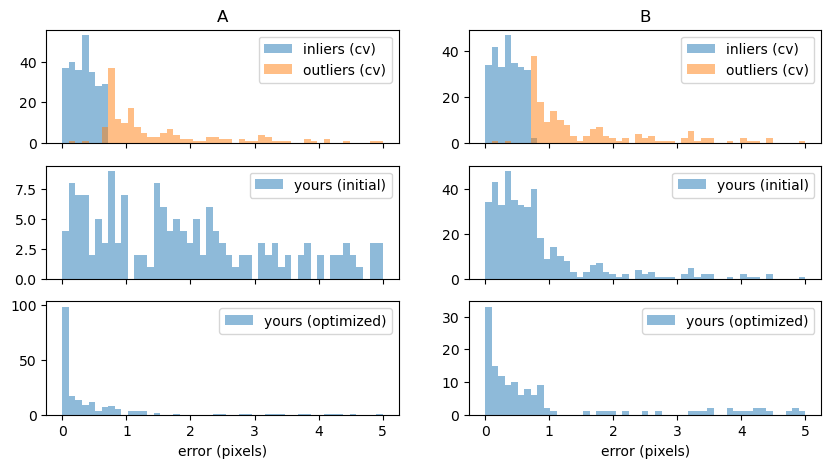

In [38]:
fig, ax = plt.subplots(3, 2, figsize=(10, 5), sharex=True)
bins = np.linspace(0, 5, 50)

ax[0, 0].hist(e_a_inliers_cv, bins, alpha=0.5, label=f'inliers (cv)')
ax[0, 0].hist(e_a_outliers_cv, bins, alpha=0.5, label=f'outliers (cv)')
ax[0, 0].legend()
ax[0, 1].hist(e_b_inliers_cv, bins, alpha=0.5, label=f'inliers (cv)')
ax[0, 1].hist(e_b_outliers_cv, bins, alpha=0.5, label=f'outliers (cv)')
ax[0, 1].legend()
ax[0, 0].set_title(f'A')
ax[0, 1].set_title(f'B')

ax[1, 0].hist(e_a, bins, alpha=0.5, label=f'yours (initial)')
ax[1, 0].legend()
ax[1, 1].hist(e_b, bins, alpha=0.5, label=f'yours (initial)')
ax[1, 1].legend()

ax[2, 0].hist(e_a_sf, bins, alpha=0.5, label=f'yours (optimized)')
ax[2, 0].legend()
ax[2, 1].hist(e_b_sf, bins, alpha=0.5, label=f'yours (optimized)')
ax[2, 1].legend()

ax[2, 0].set_xlabel('error (pixels)')
ax[2, 1].set_xlabel('error (pixels)')
plt.show()

Rename variables for easier use in the optimizer

In [40]:
R_inB1_ofA= np.eye(3)
R_inB2_ofA= R_inB_ofA_sf
p_inB1_ofA= np.zeros(3)
p_inB2_ofA= p_inB_ofA_sf



In [41]:
import symforce
#symforce.set_epsilon_to_symbol() # <-- must be done first and exactly once
import symforce.symbolic as sf
from symforce.values import Values
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce.opt.noise_models import PseudoHuberNoiseModel
from symforce.opt.noise_models import BarronNoiseModel
import sym

import numpy as np
import secrets
import json
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.linalg import sqrtm

In [42]:
seed = secrets.randbits(32)
print(f'seeding RNG with {seed}')
rng = np.random.default_rng(seed)

seeding RNG with 784448671


In [43]:
# Rename the variables we need, for convenience
b_1 = b0[0]
b_2 = b1[0]
p_inA_true = p_inA_new[0] 


In [44]:
from time import sleep
from tqdm import tqdm
count=0


Start optimizing the triangulation of $p^A$. The code only optimizes one $p^A$ point at a time, so we repeat this process for all $p^A$s that we have. For some reason, on our machines the optimizer runs fastest when it does 30 iterations at a time. 

In [47]:

p_inA_total=[]
for i in tqdm (range (0, 30)):
    # Rename the variables we need, for convenience
    b_1 = b0[i]
    b_2 = b1[i]

    p_inA_true = p_inA_new[i]

    
    
    def sf_projection(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,
    ) -> sf.V2:
        """
        Symbolic function that projects a point into an image. (If the depth
        of this point is non-positive, then the projection will be pushed far
        away from the image center.)
        """
        p_inC = T_inC_ofW * p_inW
        z = sf.Max(p_inC[2], epsilon)   # <-- if depth is non-positive, then projection
                                        #     will be pushed far away from image center
        return sf.V2(
            fx * (p_inC[0] / z) + cx,
            fy * (p_inC[1] / z) + cy,
        )

    def sf_projection_residual(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    q: sf.V2,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,  
    ) -> sf.V2:

        q_proj = sf_projection(T_inC_ofW, p_inW, fx, fy, cx, cy, epsilon)
        return sf.V2(q_proj - q)

    

        # Create data structures
    # - Initial values
    initial_values = Values(
        fx=K[0, 0],
        fy=K[1, 1],
        cx=K[0, 2],
        cy=K[1, 2],
        T_inB1_ofA=sym.Pose3(
            R=sym.Rot3.from_rotation_matrix(R_inB1_ofA),
            t=p_inB1_ofA,
        ),
        T_inB2_ofA=sym.Pose3(
            R=sym.Rot3.from_rotation_matrix(R_inB2_ofA),
            t=p_inB2_ofA,
        ),
        p_inA=p_inA_new[0],
        b_1=b_1,
        b_2=b_2,
        epsilon=sym.epsilon,
    )
    # - Optimized keys (i.e., variables to be optimized)
    optimized_keys = ['p_inA']
    # - Factors (i.e., terms in the residual)
    factors = [
        Factor(
            residual=sf_projection_residual,
            keys=[
                f'T_inB1_ofA',
                f'p_inA',
                f'b_1',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ],
        ),
        Factor(
            residual=sf_projection_residual,
            keys=[
                f'T_inB2_ofA',
                f'p_inA',
                f'b_2',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ],
        ),
    ]
   
    # Create optimizer
    optimizer = Optimizer(
        factors=factors,
        optimized_keys=optimized_keys,
        debug_stats=True,
        params=Optimizer.Params(
            iterations=100,
            use_diagonal_damping=True,
            lambda_down_factor=0.1,
            lambda_up_factor=5.,
            early_exit_min_reduction=1e-10,
        ),
    )
    
    result = optimizer.optimize(initial_values)
    assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)
    count=count+1
    p_inA_sf = result.optimized_values['p_inA']

    p_inA_total.append(p_inA_sf)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 420.15it/s]

[2024-05-10 21:15:47.448] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 8.665e+00/0.000e+00/8.656e+00, rel reduction: 1.01866e-03
[2024-05-10 21:15:47.448] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 8.656e+00/0.000e+00/8.652e+00, rel reduction: 4.23711e-04
[2024-05-10 21:15:47.448] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 8.652e+00/0.000e+00/8.645e+00, rel reduction: 8.99420e-04
[2024-05-10 21:15:47.448] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 8.645e+00/0.000e+00/8.603e+00, rel reduction: 4.80184e-03
[2024-05-10 21:15:47.449] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 8.603e+00/0.000e+00/8.571e+00, rel reduction: 3.67952e-03
[2024-05-10 21:15:47.449] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 8.571e+00/0.000e+00/8.570e+00, rel reduction: 1.08314e-04
[2024-05-10 21:15:47.4

0e-06, error prev/linear/new: 1.967e+02/0.000e+00/1.967e+02, rel reduction: 1.09421e-06
[2024-05-10 21:15:47.472] [info] LM<sym::Optimize> [iter   12] lambda: 1.250e-07, error prev/linear/new: 1.967e+02/0.000e+00/1.967e+02, rel reduction: 4.14818e-10
[2024-05-10 21:15:47.472] [info] LM<sym::Optimize> [iter   13] lambda: 1.250e-08, error prev/linear/new: 1.967e+02/0.000e+00/1.967e+02, rel reduction: 1.42451e-13
[2024-05-10 21:15:47.474] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.061e+06/0.000e+00/2.949e+05, rel reduction: 7.22100e-01
[2024-05-10 21:15:47.474] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 2.949e+05/0.000e+00/3.573e+04, rel reduction: 8.78853e-01
[2024-05-10 21:15:47.474] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 3.573e+04/0.000e+00/2.555e+03, rel reduction: 9.28474e-01
[2024-05-10 21:15:47.474] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/line

In [48]:
for i in tqdm (range (30, 60)):
   # Rename the variables we need, for convenience
    b_1 = b0[i]
    b_2 = b1[i]
    p_inA_true = p_inA_new[i]

    
    def sf_projection(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,
    ) -> sf.V2:
        """
        Symbolic function that projects a point into an image. (If the depth
        of this point is non-positive, then the projection will be pushed far
        away from the image center.)
        """
        p_inC = T_inC_ofW * p_inW
        z = sf.Max(p_inC[2], epsilon)   # <-- if depth is non-positive, then projection
                                        #     will be pushed far away from image center
        return sf.V2(
            fx * (p_inC[0] / z) + cx,
            fy * (p_inC[1] / z) + cy,
        )

    def sf_projection_residual(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    q: sf.V2,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,  
    ) -> sf.V2:

        q_proj = sf_projection(T_inC_ofW, p_inW, fx, fy, cx, cy, epsilon)
        return sf.V2(q_proj - q)

    

        # Create data structures
    # - Initial values
    initial_values = Values(
        fx=K[0, 0],
        fy=K[1, 1],
        cx=K[0, 2],
        cy=K[1, 2],
        T_inB1_ofA=sym.Pose3(
            R=sym.Rot3.from_rotation_matrix(R_inB1_ofA),
            t=p_inB1_ofA,
        ),
        T_inB2_ofA=sym.Pose3(
            R=sym.Rot3.from_rotation_matrix(R_inB2_ofA),
            t=p_inB2_ofA,
        ),
        p_inA=p_inA_new[0],
        b_1=b_1,
        b_2=b_2,
        epsilon=sym.epsilon,
    )
    # - Optimized keys (i.e., variables to be optimized)
    optimized_keys = ['p_inA']
    # - Factors (i.e., terms in the residual)
    factors = [
        Factor(
            residual=sf_projection_residual,
            keys=[
                f'T_inB1_ofA',
                f'p_inA',
                f'b_1',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ],
        ),
        Factor(
            residual=sf_projection_residual,
            keys=[
                f'T_inB2_ofA',
                f'p_inA',
                f'b_2',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ],
        ),
    ]
   
    # Create optimizer
    optimizer = Optimizer(
        factors=factors,
        optimized_keys=optimized_keys,
        debug_stats=True,
        params=Optimizer.Params(
            iterations=100,
            use_diagonal_damping=True,
            lambda_down_factor=0.1,
            lambda_up_factor=5.,
            early_exit_min_reduction=1e-10,
        ),
    )
    
    result = optimizer.optimize(initial_values)
    assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)
    count=count+1
    p_inA_sf = result.optimized_values['p_inA']

    p_inA_total.append(p_inA_sf)

  0%|                                                                                                                                                                              | 0/30 [00:00<?, ?it/s]

[2024-05-10 21:15:47.720] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 2.450e+03/0.000e+00/2.952e+02, rel reduction: 8.79474e-01
[2024-05-10 21:15:47.720] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 2.952e+02/0.000e+00/4.873e+00, rel reduction: 9.83495e-01
[2024-05-10 21:15:47.721] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 4.873e+00/0.000e+00/3.624e+00, rel reduction: 2.56312e-01
[2024-05-10 21:15:47.721] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 3.624e+00/0.000e+00/1.844e+00, rel reduction: 4.91274e-01
[2024-05-10 21:15:47.721] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 1.844e+00/0.000e+00/5.284e-01, rel reduction: 7.13389e-01
[2024-05-10 21:15:47.721] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 5.284e-01/0.000e+00/5.061e-01, rel reduction: 4.21163e-02


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 278.52it/s]

[2024-05-10 21:15:47.721] [info] LM<sym::Optimize> [iter    6] lambda: 1.000e-06, error prev/linear/new: 5.061e-01/0.000e+00/5.061e-01, rel reduction: 6.80316e-06
[2024-05-10 21:15:47.721] [info] LM<sym::Optimize> [iter    7] lambda: 1.000e-07, error prev/linear/new: 5.061e-01/0.000e+00/5.061e-01, rel reduction: 2.06847e-11
[2024-05-10 21:15:47.725] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.683e+04/0.000e+00/3.140e+03, rel reduction: 8.13408e-01
[2024-05-10 21:15:47.725] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 3.140e+03/0.000e+00/9.349e+01, rel reduction: 9.70228e-01
[2024-05-10 21:15:47.725] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 9.349e+01/0.000e+00/6.055e+01, rel reduction: 3.52287e-01
[2024-05-10 21:15:47.725] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 6.055e+01/0.000e+00/2.852e+01, rel reduction: 5.28986e-01
[2024-05-10 21:15:47.7

: 1.000e-05, error prev/linear/new: 1.206e+02/0.000e+00/1.190e+02, rel reduction: 1.33182e-02
[2024-05-10 21:15:47.790] [info] LM<sym::Optimize> [iter    6] lambda: 1.000e-06, error prev/linear/new: 1.190e+02/0.000e+00/1.190e+02, rel reduction: 7.03456e-06
[2024-05-10 21:15:47.790] [info] LM<sym::Optimize> [iter    7] lambda: 1.000e-07, error prev/linear/new: 1.190e+02/0.000e+00/1.190e+02, rel reduction: 8.64116e-10
[2024-05-10 21:15:47.790] [info] LM<sym::Optimize> [iter    8] lambda: 1.000e-08, error prev/linear/new: 1.190e+02/0.000e+00/1.190e+02, rel reduction: 1.29673e-13
[2024-05-10 21:15:47.792] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 4.285e+05/0.000e+00/9.762e+04, rel reduction: 7.72178e-01
[2024-05-10 21:15:47.792] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 9.762e+04/0.000e+00/5.822e+03, rel reduction: 9.40362e-01
[2024-05-10 21:15:47.792] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error pre

[2024-05-10 21:15:47.804] [info] LM<sym::Optimize> [iter    7] lambda: 1.000e-07, error prev/linear/new: 2.278e+02/0.000e+00/2.278e+02, rel reduction: 3.87650e-08
[2024-05-10 21:15:47.804] [info] LM<sym::Optimize> [iter    8] lambda: 1.000e-08, error prev/linear/new: 2.278e+02/0.000e+00/2.278e+02, rel reduction: 1.29818e-11
[2024-05-10 21:15:47.806] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 7.553e+05/0.000e+00/1.956e+05, rel reduction: 7.40967e-01
[2024-05-10 21:15:47.806] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 1.956e+05/0.000e+00/1.682e+04, rel reduction: 9.14033e-01
[2024-05-10 21:15:47.806] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 1.682e+04/0.000e+00/1.270e+03, rel reduction: 9.24491e-01
[2024-05-10 21:15:47.806] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 1.270e+03/0.000e+00/1.126e+04, rel reduction: -7.87044e+00
[2024-05-10 21:15:47.

In [49]:

for i in tqdm (range (60, 90)):
    # Rename the variables we need, for convenience
    b_1 = b0[i]#data['b_0']
    b_2 = b1[i]#data['b_1']
    #R_inB1_ofA = data['R_inB0_ofA']
    #R_inB2_ofA = data['R_inB1_ofA']
    #p_inB1_ofA = data['p_inB0_ofA']
    #p_inB2_ofA = data['p_inB1_ofA']
    p_inA_true = p_inA_new[i] #data['p_inA']
    #K = np.array(data['K'])
    
    
    def sf_projection(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,
    ) -> sf.V2:
        """
        Symbolic function that projects a point into an image. (If the depth
        of this point is non-positive, then the projection will be pushed far
        away from the image center.)
        """
        p_inC = T_inC_ofW * p_inW
        z = sf.Max(p_inC[2], epsilon)   # <-- if depth is non-positive, then projection
                                        #     will be pushed far away from image center
        return sf.V2(
            fx * (p_inC[0] / z) + cx,
            fy * (p_inC[1] / z) + cy,
        )

    def sf_projection_residual(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    q: sf.V2,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,  
    ) -> sf.V2:

        q_proj = sf_projection(T_inC_ofW, p_inW, fx, fy, cx, cy, epsilon)
        return sf.V2(q_proj - q)

    

        # Create data structures
    # - Initial values
    initial_values = Values(
        fx=K[0, 0],
        fy=K[1, 1],
        cx=K[0, 2],
        cy=K[1, 2],
        T_inB1_ofA=sym.Pose3(
            R=sym.Rot3.from_rotation_matrix(R_inB1_ofA),
            t=p_inB1_ofA,
        ),
        T_inB2_ofA=sym.Pose3(
            R=sym.Rot3.from_rotation_matrix(R_inB2_ofA),
            t=p_inB2_ofA,
        ),
        p_inA=p_inA_new[0],
        b_1=b_1,
        b_2=b_2,
        epsilon=sym.epsilon,
    )
    # - Optimized keys (i.e., variables to be optimized)
    optimized_keys = ['p_inA']
    # - Factors (i.e., terms in the residual)
    factors = [
        Factor(
            residual=sf_projection_residual,
            keys=[
                f'T_inB1_ofA',
                f'p_inA',
                f'b_1',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ],
        ),
        Factor(
            residual=sf_projection_residual,
            keys=[
                f'T_inB2_ofA',
                f'p_inA',
                f'b_2',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ],
        ),
    ]
   
    # Create optimizer
    optimizer = Optimizer(
        factors=factors,
        optimized_keys=optimized_keys,
        debug_stats=True,
        params=Optimizer.Params(
            iterations=100,
            use_diagonal_damping=True,
            lambda_down_factor=0.1,
            lambda_up_factor=5.,
            early_exit_min_reduction=1e-10,
        ),
    )
    
    result = optimizer.optimize(initial_values)
    assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)
    count=count+1
    p_inA_sf = result.optimized_values['p_inA']

    p_inA_total.append(p_inA_sf)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 298.63it/s]

[2024-05-10 21:15:48.114] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.683e+05/0.000e+00/3.038e+04, rel reduction: 8.19478e-01
[2024-05-10 21:15:48.114] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 3.038e+04/0.000e+00/1.370e+03, rel reduction: 9.54917e-01
[2024-05-10 21:15:48.115] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 1.370e+03/0.000e+00/6.593e+02, rel reduction: 5.18613e-01
[2024-05-10 21:15:48.115] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 6.593e+02/0.000e+00/3.276e+01, rel reduction: 9.50307e-01
[2024-05-10 21:15:48.115] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 3.276e+01/0.000e+00/9.061e+00, rel reduction: 7.23449e-01
[2024-05-10 21:15:48.115] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 9.061e+00/0.000e+00/8.876e+00, rel reduction: 2.03769e-02
[2024-05-10 21:15:48.1

 21:15:48.155] [info] LM<sym::Optimize> [iter    5] lambda: 2.500e-02, error prev/linear/new: 1.453e+03/0.000e+00/1.197e+03, rel reduction: 1.75959e-01
[2024-05-10 21:15:48.155] [info] LM<sym::Optimize> [iter    6] lambda: 2.500e-03, error prev/linear/new: 1.197e+03/0.000e+00/3.401e+36, rel reduction: -2.84068e+33
[2024-05-10 21:15:48.156] [info] LM<sym::Optimize> [iter    7] lambda: 1.250e-02, error prev/linear/new: 1.197e+03/0.000e+00/6.495e+02, rel reduction: 4.57453e-01
[2024-05-10 21:15:48.156] [info] LM<sym::Optimize> [iter    8] lambda: 1.250e-03, error prev/linear/new: 6.495e+02/0.000e+00/5.818e+08, rel reduction: -8.95743e+05
[2024-05-10 21:15:48.156] [info] LM<sym::Optimize> [iter    9] lambda: 6.250e-03, error prev/linear/new: 6.495e+02/0.000e+00/2.412e+02, rel reduction: 6.28638e-01
[2024-05-10 21:15:48.156] [info] LM<sym::Optimize> [iter   10] lambda: 6.250e-04, error prev/linear/new: 2.412e+02/0.000e+00/8.265e+01, rel reduction: 6.57360e-01
[2024-05-10 21:15:48.156] [info

[2024-05-10 21:15:48.176] [info] LM<sym::Optimize> [iter   15] lambda: 3.125e-07, error prev/linear/new: 2.264e+02/0.000e+00/2.264e+02, rel reduction: 1.54057e-09
[2024-05-10 21:15:48.176] [info] LM<sym::Optimize> [iter   16] lambda: 3.125e-08, error prev/linear/new: 2.264e+02/0.000e+00/2.264e+02, rel reduction: 1.19948e-12
[2024-05-10 21:15:48.178] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 8.969e+05/0.000e+00/2.329e+05, rel reduction: 7.40332e-01
[2024-05-10 21:15:48.178] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 2.329e+05/0.000e+00/3.051e+04, rel reduction: 8.68978e-01
[2024-05-10 21:15:48.178] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 3.051e+04/0.000e+00/1.762e+03, rel reduction: 9.42240e-01
[2024-05-10 21:15:48.178] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 1.762e+03/0.000e+00/6.814e+37, rel reduction: -3.86619e+34
[2024-05-10 21:15:48.

In [50]:

for i in tqdm (range (90, 120)):
    # Rename the variables we need, for convenience
    b_1 = b0[i]#data['b_0']
    b_2 = b1[i]#data['b_1']
    #R_inB1_ofA = data['R_inB0_ofA']
    #R_inB2_ofA = data['R_inB1_ofA']
    #p_inB1_ofA = data['p_inB0_ofA']
    #p_inB2_ofA = data['p_inB1_ofA']
    p_inA_true = p_inA_new[i] #data['p_inA']
    #K = np.array(data['K'])
    
    
    def sf_projection(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,
    ) -> sf.V2:
        """
        Symbolic function that projects a point into an image. (If the depth
        of this point is non-positive, then the projection will be pushed far
        away from the image center.)
        """
        p_inC = T_inC_ofW * p_inW
        z = sf.Max(p_inC[2], epsilon)   # <-- if depth is non-positive, then projection
                                        #     will be pushed far away from image center
        return sf.V2(
            fx * (p_inC[0] / z) + cx,
            fy * (p_inC[1] / z) + cy,
        )

    def sf_projection_residual(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    q: sf.V2,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,  
    ) -> sf.V2:

        q_proj = sf_projection(T_inC_ofW, p_inW, fx, fy, cx, cy, epsilon)
        return sf.V2(q_proj - q)

    

        # Create data structures
    # - Initial values
    initial_values = Values(
        fx=K[0, 0],
        fy=K[1, 1],
        cx=K[0, 2],
        cy=K[1, 2],
        T_inB1_ofA=sym.Pose3(
            R=sym.Rot3.from_rotation_matrix(R_inB1_ofA),
            t=p_inB1_ofA,
        ),
        T_inB2_ofA=sym.Pose3(
            R=sym.Rot3.from_rotation_matrix(R_inB2_ofA),
            t=p_inB2_ofA,
        ),
        p_inA=p_inA_new[0],
        b_1=b_1,
        b_2=b_2,
        epsilon=sym.epsilon,
    )
    # - Optimized keys (i.e., variables to be optimized)
    optimized_keys = ['p_inA']
    # - Factors (i.e., terms in the residual)
    factors = [
        Factor(
            residual=sf_projection_residual,
            keys=[
                f'T_inB1_ofA',
                f'p_inA',
                f'b_1',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ],
        ),
        Factor(
            residual=sf_projection_residual,
            keys=[
                f'T_inB2_ofA',
                f'p_inA',
                f'b_2',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ],
        ),
    ]
   
    # Create optimizer
    optimizer = Optimizer(
        factors=factors,
        optimized_keys=optimized_keys,
        debug_stats=True,
        params=Optimizer.Params(
            iterations=100,
            use_diagonal_damping=True,
            lambda_down_factor=0.1,
            lambda_up_factor=5.,
            early_exit_min_reduction=1e-10,
        ),
    )
    
    result = optimizer.optimize(initial_values)
    assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)
    count=count+1
    p_inA_sf = result.optimized_values['p_inA']

    p_inA_total.append(p_inA_sf)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 287.23it/s]

[2024-05-10 21:15:48.573] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 3.568e+05/0.000e+00/7.529e+04, rel reduction: 7.89003e-01
[2024-05-10 21:15:48.573] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 7.529e+04/0.000e+00/4.602e+03, rel reduction: 9.38871e-01
[2024-05-10 21:15:48.573] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 4.602e+03/0.000e+00/1.252e+03, rel reduction: 7.27873e-01
[2024-05-10 21:15:48.573] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 1.252e+03/0.000e+00/1.097e+36, rel reduction: -8.75967e+32
[2024-05-10 21:15:48.573] [info] LM<sym::Optimize> [iter    4] lambda: 5.000e-03, error prev/linear/new: 1.252e+03/0.000e+00/7.629e+02, rel reduction: 3.90808e-01
[2024-05-10 21:15:48.573] [info] LM<sym::Optimize> [iter    5] lambda: 5.000e-04, error prev/linear/new: 7.629e+02/0.000e+00/1.047e+33, rel reduction: -1.37247e+30
[2024-05-10 21:15:48


[2024-05-10 21:15:48.621] [info] LM<sym::Optimize> [iter   13] lambda: 6.250e-07, error prev/linear/new: 1.076e+00/0.000e+00/1.076e+00, rel reduction: 2.76115e-07
[2024-05-10 21:15:48.621] [info] LM<sym::Optimize> [iter   14] lambda: 6.250e-08, error prev/linear/new: 1.076e+00/0.000e+00/1.076e+00, rel reduction: 4.79799e-13
[2024-05-10 21:15:48.623] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 6.908e+05/0.000e+00/1.672e+05, rel reduction: 7.57983e-01
[2024-05-10 21:15:48.624] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 1.672e+05/0.000e+00/1.743e+04, rel reduction: 8.95755e-01
[2024-05-10 21:15:48.624] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 1.743e+04/0.000e+00/1.828e+03, rel reduction: 8.95103e-01
[2024-05-10 21:15:48.624] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 1.828e+03/0.000e+00/3.003e+38, rel reduction: -1.64251e+35
[2024-05-10 21:15:48

[2024-05-10 21:15:48.656] [info] LM<sym::Optimize> [iter   13] lambda: 1.250e-08, error prev/linear/new: 1.988e+01/0.000e+00/1.988e+01, rel reduction: 3.21923e-13
[2024-05-10 21:15:48.658] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 6.954e+05/0.000e+00/1.693e+05, rel reduction: 7.56487e-01
[2024-05-10 21:15:48.658] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 1.693e+05/0.000e+00/1.734e+04, rel reduction: 8.97610e-01
[2024-05-10 21:15:48.658] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 1.734e+04/0.000e+00/2.051e+03, rel reduction: 8.81718e-01
[2024-05-10 21:15:48.658] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 2.051e+03/0.000e+00/1.859e+38, rel reduction: -9.06539e+34
[2024-05-10 21:15:48.658] [info] LM<sym::Optimize> [iter    4] lambda: 5.000e-03, error prev/linear/new: 2.051e+03/0.000e+00/1.557e+36, rel reduction: -7.59092e+32
[2024-05-10 21:15:48

In [51]:
#p_inA_total=p_inA_total.tolist()
for i in tqdm (range (120, len(b0))):
    # Rename the variables we need, for convenience
    b_1 = b0[i]#data['b_0']
    b_2 = b1[i]#data['b_1']
    #R_inB1_ofA = data['R_inB0_ofA']
    #R_inB2_ofA = data['R_inB1_ofA']
    #p_inB1_ofA = data['p_inB0_ofA']
    #p_inB2_ofA = data['p_inB1_ofA']
    p_inA_true = p_inA_new[i] #data['p_inA']
    #K = np.array(data['K'])
    
    
    def sf_projection(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,
    ) -> sf.V2:
        """
        Symbolic function that projects a point into an image. (If the depth
        of this point is non-positive, then the projection will be pushed far
        away from the image center.)
        """
        p_inC = T_inC_ofW * p_inW
        z = sf.Max(p_inC[2], epsilon)   # <-- if depth is non-positive, then projection
                                        #     will be pushed far away from image center
        return sf.V2(
            fx * (p_inC[0] / z) + cx,
            fy * (p_inC[1] / z) + cy,
        )

    def sf_projection_residual(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    q: sf.V2,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,  
    ) -> sf.V2:

        q_proj = sf_projection(T_inC_ofW, p_inW, fx, fy, cx, cy, epsilon)
        return sf.V2(q_proj - q)

    

        # Create data structures
    # - Initial values
    initial_values = Values(
        fx=K[0, 0],
        fy=K[1, 1],
        cx=K[0, 2],
        cy=K[1, 2],
        T_inB1_ofA=sym.Pose3(
            R=sym.Rot3.from_rotation_matrix(R_inB1_ofA),
            t=p_inB1_ofA,
        ),
        T_inB2_ofA=sym.Pose3(
            R=sym.Rot3.from_rotation_matrix(R_inB2_ofA),
            t=p_inB2_ofA,
        ),
        p_inA=p_inA_new[0],
        b_1=b_1,
        b_2=b_2,
        epsilon=sym.epsilon,
    )
    # - Optimized keys (i.e., variables to be optimized)
    optimized_keys = ['p_inA']
    # - Factors (i.e., terms in the residual)
    factors = [
        Factor(
            residual=sf_projection_residual,
            keys=[
                f'T_inB1_ofA',
                f'p_inA',
                f'b_1',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ],
        ),
        Factor(
            residual=sf_projection_residual,
            keys=[
                f'T_inB2_ofA',
                f'p_inA',
                f'b_2',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ],
        ),
    ]
   
    # Create optimizer
    optimizer = Optimizer(
        factors=factors,
        optimized_keys=optimized_keys,
        debug_stats=True,
        params=Optimizer.Params(
            iterations=100,
            use_diagonal_damping=True,
            lambda_down_factor=0.1,
            lambda_up_factor=5.,
            early_exit_min_reduction=1e-10,
        ),
    )
    
    result = optimizer.optimize(initial_values)
    assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)
    count=count+1
    p_inA_sf = result.optimized_values['p_inA']

    p_inA_total.append(p_inA_sf)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.20it/s]

[2024-05-10 21:15:49.042] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 9.511e+05/0.000e+00/2.489e+05, rel reduction: 7.38337e-01
[2024-05-10 21:15:49.042] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 2.489e+05/0.000e+00/3.569e+04, rel reduction: 8.56582e-01
[2024-05-10 21:15:49.042] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 3.569e+04/0.000e+00/3.906e+03, rel reduction: 8.90566e-01
[2024-05-10 21:15:49.042] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 3.906e+03/0.000e+00/1.890e+38, rel reduction: -4.83785e+34
[2024-05-10 21:15:49.042] [info] LM<sym::Optimize> [iter    4] lambda: 5.000e-03, error prev/linear/new: 3.906e+03/0.000e+00/4.664e+35, rel reduction: -1.19401e+32
[2024-05-10 21:15:49.043] [info] LM<sym::Optimize> [iter    5] lambda: 2.500e-02, error prev/linear/new: 3.906e+03/0.000e+00/1.830e+03, rel reduction: 5.31512e-01
[2024-05-10 21:15:49

+33
[2024-05-10 21:15:49.062] [info] LM<sym::Optimize> [iter    6] lambda: 2.500e-03, error prev/linear/new: 3.797e+03/0.000e+00/2.089e+03, rel reduction: 4.49712e-01
[2024-05-10 21:15:49.062] [info] LM<sym::Optimize> [iter    7] lambda: 2.500e-04, error prev/linear/new: 2.089e+03/0.000e+00/1.710e+38, rel reduction: -8.18248e+34
[2024-05-10 21:15:49.062] [info] LM<sym::Optimize> [iter    8] lambda: 1.250e-03, error prev/linear/new: 2.089e+03/0.000e+00/1.175e+36, rel reduction: -5.62426e+32
[2024-05-10 21:15:49.062] [info] LM<sym::Optimize> [iter    9] lambda: 6.250e-03, error prev/linear/new: 2.089e+03/0.000e+00/1.750e+03, rel reduction: 1.62537e-01
[2024-05-10 21:15:49.062] [info] LM<sym::Optimize> [iter   10] lambda: 6.250e-04, error prev/linear/new: 1.750e+03/0.000e+00/1.137e+37, rel reduction: -6.49579e+33
[2024-05-10 21:15:49.063] [info] LM<sym::Optimize> [iter   11] lambda: 3.125e-03, error prev/linear/new: 1.750e+03/0.000e+00/1.042e+03, rel reduction: 4.04560e-01
[2024-05-10 21:

In [53]:
p_inA_total=np.array(p_inA_total)

Compute reprojection error and only plot those that are within a certain threshold. 

In [55]:
e_a_sf = projection_error(K, np.eye(3), np.zeros(3), p_inA_total, b0)
e_b_sf = projection_error(K, R_inB_ofA_sf, p_inB_ofA_sf, p_inA_total, b1)


b0plot=[]
b1plot=[]
a_pred = project(K, np.eye(3), np.zeros(3), p_inA_total)
b_pred = project(K, R_inB2_ofA, p_inB2_ofA, p_inA_total)
inrange=[]
a_pred_plot=[]
b_pred_plot=[]
for i in range(len(p_inA_total)):
    if e_a_sf[i] < 0.4 and e_b_sf[i] < 0.4:
        b0plot.append(b0[i])
        b1plot.append(b1[i])
        a_pred_plot.append(a_pred[i])
        b_pred_plot.append(b_pred[i])
        inrange.append(p_inA_total)

In [56]:
b0plot=np.array(b0plot)
b1plot=np.array(b1plot)
a_pred_plot= np.array(a_pred_plot)
b_pred_plot= np.array(b_pred_plot)

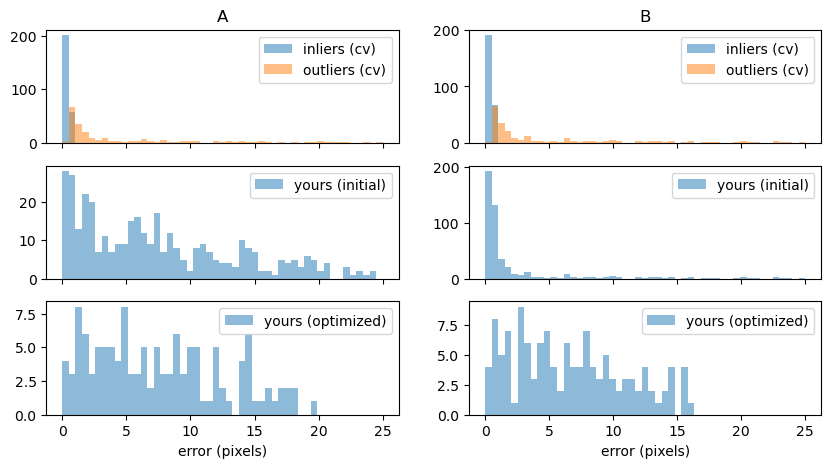

In [57]:
fig, ax = plt.subplots(3, 2, figsize=(10, 5), sharex=True)
bins = np.linspace(0, 25, 50)

ax[0, 0].hist(e_a_inliers_cv, bins, alpha=0.5, label=f'inliers (cv)')
ax[0, 0].hist(e_a_outliers_cv, bins, alpha=0.5, label=f'outliers (cv)')
ax[0, 0].legend()
ax[0, 1].hist(e_b_inliers_cv, bins, alpha=0.5, label=f'inliers (cv)')
ax[0, 1].hist(e_b_outliers_cv, bins, alpha=0.5, label=f'outliers (cv)')
ax[0, 1].legend()
ax[0, 0].set_title(f'A')
ax[0, 1].set_title(f'B')

ax[1, 0].hist(e_a, bins, alpha=0.5, label=f'yours (initial)')
ax[1, 0].legend()
ax[1, 1].hist(e_b, bins, alpha=0.5, label=f'yours (initial)')
ax[1, 1].legend()

ax[2, 0].hist(e_a_sf, bins, alpha=0.5, label=f'yours (optimized)')
ax[2, 0].legend()
ax[2, 1].hist(e_b_sf, bins, alpha=0.5, label=f'yours (optimized)')
ax[2, 1].legend()

ax[2, 0].set_xlabel('error (pixels)')
ax[2, 1].set_xlabel('error (pixels)')
plt.show()

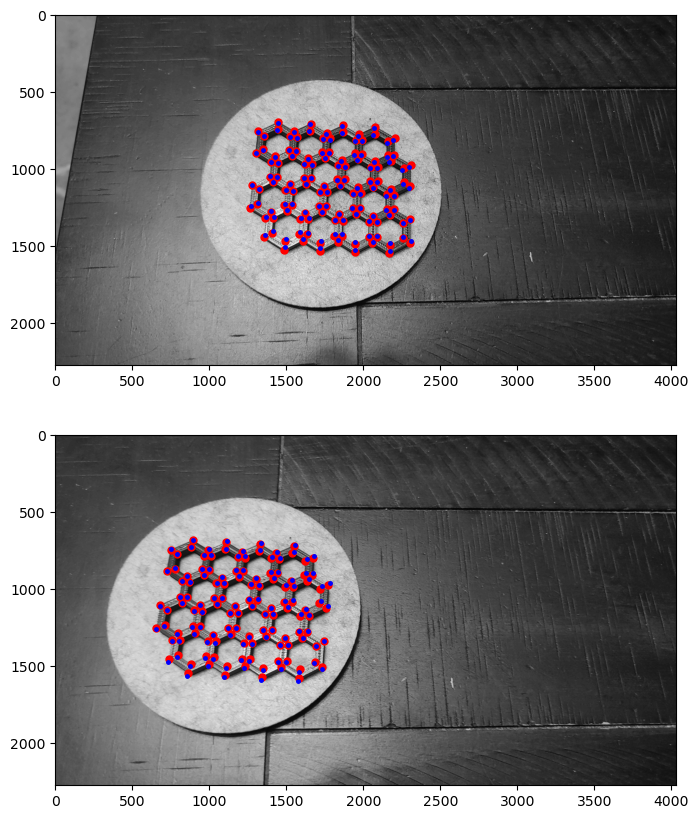

In [58]:
# Sample code with reduced number of points and increased marker size
import matplotlib.pyplot as plt

# Create figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

# Show images
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')

a_pred = project(K, np.eye(3), np.zeros(3), p_inA_new)
b_pred = project(K, R_inB_ofA_sf, p_inB_ofA_sf, p_inA_new)
# Plot points
ax1.plot(b0[:, 0], b0[:, 1], 'r.', markersize=10)
ax1.plot(a_pred[:, 0], a_pred[:, 1], 'b.', markersize=5)  # Increased marker size


ax2.plot(b1[:, 0], b1[:, 1], 'r.', markersize=10)
ax2.plot(b_pred[:, 0], b_pred[:, 1], 'b.', markersize = 5)
plt.show()


In [58]:
print(p_inA_total.tolist())

[[-10.345575895399529, -6.462321887483662, 45.3404403086551], [-7.46030664129934, -6.410555960146108, 39.873515956074435], [-4.740473935251082, -4.359298987860164, 30.53879788067317], [-3.63997554104839, -4.707009050770061, 29.78158693172464], [-2.0771655026372553, -3.2281326181312036, 23.112583562761937], [-1.2666157985379087, -3.4732195224219424, 22.366397358435353], [-0.4784633934999833, -2.6599723924853502, 19.48227729845464], [0.16167704388193666, -3.0009585782789747, 19.73498601869463], [0.7546184384442839, -2.055241044803662, 15.891875424696504], [0.6539346587356473, -1.3139813288157771, 13.756006786906875], [0.9357444514775971, -0.8761163439100583, 11.606308790292493], [0.8077383678749155, -0.32343901126405694, 10.086227658304455], [0.499138905160123, -0.1740840376518589, 10.51130622363721], [0.4570606514713047, 0.11915410391199441, 9.677648116406203], [0.6809089860242836, 0.26362260865340703, 8.505765734384214], [0.6676808411318451, 0.6504665857770248, 8.463128860234471], [0.3

In [59]:
print(b0.dtype)

float64
